In [3]:
%load_ext autoreload
%autoreload 2
import datasets
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from clara_dataloader import ClaraAnalysis, ClaraHelperMethods

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
util = ClaraHelperMethods()
clara = ClaraAnalysis(dataset_path='../problems/dataset')

Loading cached processed dataset at /home/mac9908/clara/problems/dataset/final/cache-016d360c4763a9a3.arrow


Map:   0%|          | 0/258848 [00:00<?, ? examples/s]

Test Available
Technique  Test Available
CLARA      No                25396
           Yes               66327
FA(L)      No                25396
           Yes               58961
FA(L+E)    No                25396
           Yes               57070
Name: Technique, dtype: int64
List of Parse Errors:
Parse Error Output
 'Import' object has no attribute 'name'                                           534
 'Subscript' object has no attribute 'id'                                           32
 Assignments to Attribute not supported                                           4244
 Assignments to List not supported                                                 351
 Call of Call not supported                                                         11
 Call of Subscript not supported                                                     5
 Call to Attribute                                                                 237
 Comprehension: not a list of names                                  

## Simulate SARFGEN Data

In [31]:
# unfiltered_df = clara.dataset['final'].to_pandas()
df = clara.dataset['final'].to_pandas()

In [50]:
def simulate_sarfgen(df, threshold=0.75, technique='FA(L+E)'):
    df['ci'] = df['Correct File'] + '_' + df['Incorrect File']
    df['similarity_score'] = df['First Output'].str.extract(r'Score: ([0-9.]*)')
    df['similarity_score'] = df['similarity_score'].astype('float')
    # d[~d['Percentage Repaired'].isna()]
    # clara.dataframe[clara.dataframe['ci']=='127317965_87592770']
    sgen = {}
    df['sarfgen'] = False
    def build_sgen(x, sgen):
        if x['similarity_score']>=threshold and x['ci'] not in sgen:
            sgen[x['ci']]=x['similarity_score']
        return x
    def sarfgen(x, sgen):
        if x['ci'] in sgen:
            x['sarfgen'] = True
            x['similarity_score'] = sgen[x['ci']]
        else:
            x['sarfgen'] = False
            x['similarity_score'] = 0
        return x
    df = df.apply(lambda x: build_sgen(x, sgen), axis=1)
    df = df.apply(lambda x: sarfgen(x, sgen), axis=1)
    df[df['sarfgen']==True].groupby('Technique').count()
    d_sarfgen = df[df['Technique']==technique]
    d_sarfgen['Technique'] = 'SARFGEN'
    def sim_sarfgen(x):
        if x['similarity_score'] < threshold:
            x['Repairs'] = None
        return x
    d_sarfgen = d_sarfgen.apply(sim_sarfgen, axis=1)
    df = pd.concat([df, d_sarfgen])
    return df

sim_df = simulate_sarfgen(df, threshold=0.70, technique='FA(L+E)')
sim_df

/tmp/ipykernel_21039/240911310.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_sarfgen['Technique'] = 'SARFGEN'


,Problem,First Output,Error Output,Correct File,Incorrect File,Test Available,Correct Locs,Incorrect Locs,Old Incorrect Locs,Correct Exprs,...,Parse Error,Cost,Second Output,Match,Percentage Repaired,Timeout,Parse Error Output,ci,similarity_score,sarfgen
0,1382B,Test Case Available\nLocs Same\n\nExitcode: 1,[debug] Guessed language: py\n[debug] Reading ...,87664234,133055919,Yes,NaN,NaN,NaN,NaN,...,False,0.0,,,None,False,None,87664234_133055919,0.772024,True
1,1382B,Test Case Available\nScore: 0.7720238095238096...,\nModel name: '' - run #1 \nObjective: M...,87664234,133055919,Yes,23.0,23.0,4.0,25.0,...,False,44.0,,,50.0,False,None,87664234_133055919,0.772024,True
2,1382B,Test Case Available\nScore: 0.6440476190476191...,\nModel name: '' - run #1 \nObjective: M...,87664234,133055919,Yes,23.0,23.0,4.0,25.0,...,False,44.0,,,50.0,False,None,87664234_133055919,0.772024,True
3,1382B,Test Case Available\nParse Error!\n\nExitcode: 1,[debug] Guessed language: py\n[debug] Reading ...,87577748,133055919,Yes,NaN,NaN,NaN,NaN,...,True,0.0,,,None,False,keyword arguments not supported,87577748_133055919,0.000000,False
4,1382B,Test Case Available\nParse Error!\n\nExitcode: 1,[debug] Guessed language: py\n[debug] Reading ...,87577748,133055919,Yes,NaN,NaN,NaN,NaN,...,True,0.0,,,None,False,keyword arguments not supported,87577748_133055919,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258832,1364A,Test Case Available\nParse Error!\n\nExitcode: 1,[debug] Guessed language: py\n[debug] Reading ...,93300180,105285701,Yes,NaN,NaN,NaN,NaN,...,True,0.0,,,None,False,Unimplemented visitor in Visit: 'Lambda',93300180_105285701,0.000000,False
258837,1364A,Test Case Available\nParse Error!\n\nExitcode: 1,[debug] Guessed language: py\n[debug] Reading ...,126770461,105285701,Yes,NaN,NaN,NaN,NaN,...,True,0.0,,,None,False,Unimplemented visitor in Visit: 'ClassDef',126770461_105285701,0.000000,False
258840,1364A,Test Case Available\nParse Error!\n\nExitcode: 1,[debug] Guessed language: py\n[debug] Reading ...,91693681,105285701,Yes,NaN,NaN,NaN,NaN,...,True,0.0,,,None,False,keyword arguments not supported,91693681_105285701,0.000000,False
258843,1364A,Test Case Available\nScore: 0.7124788715975987...,\nModel name: '' - run #1 \nObjective: M...,83643436,105285701,Yes,18.0,18.0,18.0,20.0,...,False,44.0,,,26.666666666666668,False,None,83643436_105285701,0.712479,True


## Table 5: Program comparisons available in our dataset and summary of invalidity reasons

In [51]:
def assign_bins_and_remove_no_correct(df, col):
    cfiles = df.groupby(['Correct File'])[col].max()
    mapping = {}
    for idx, c in enumerate(cfiles.index):
        mapping[c] = cfiles.values[idx]
    df[col] = df['Correct File'].map(mapping)
    return df
def do_maps(df, clara):
    df['Difficulty'] = df['Problem'].map(clara.difficulty)
    df[['prob_num', 'prob_letter']] = df['Problem'].str.extract(r'([0-9]+)([A-Z])')
    df['prob_num'] = df['prob_num'].astype(int)
    df['locs_bin'] = pd.cut(np.array(df['Correct Locs']), bins=[0,4,5,15,40,80])
    df['exprs_bin'] = pd.cut(np.array(df['Correct Exprs']), bins=[0,4,10,20,40,80])
    df = assign_bins_and_remove_no_correct(df, 'locs_bin')
    df = assign_bins_and_remove_no_correct(df, 'exprs_bin')
    return df
def ensure_equivalence(df):
    #display(df)
    df['ci'] = df['Correct File'] + '_' + df['Incorrect File']
    grouped = df.groupby('ci')
    df = grouped.filter(lambda x: x['Technique'].count() == 4)
    return df
class Calculate:
    def unavailable_test_cases(df, experiment):
        df = df[df['Technique']==experiment]
        len1 = len(df[df['Test Available'].isna()==True])
        len2 = len(df[df['Test Available']=='No'])
        return 'Unavailable Test Cases', len1+len2
    def unsupported_language_constructs(df, experiment):
        df = df[df['Technique']==experiment]
        df = df[df['Parse Error']=='True']
        len1 = len(df[df['Parse Error Output'].str.contains('Unimplemented')])
        len2 = len(df[df['Parse Error Output'].str.contains('For-Else')])
        len3 = len(df[df['Parse Error Output'].str.contains('While-Else')])
        return 'Unsupported Language Constructs', len1+len2+len3
    def keyword_arguments(df, experiment):
        df = df[df['Technique']==experiment]
        df = df[df['Parse Error']=='True']
        len1 = len(df[df['Parse Error Output'].str.contains('keyword')])
        return 'Keyword Arguments', len1
    def unsupported_class_attributes(df, experiment):
        df = df[df['Technique']==experiment]
        df = df[df['Parse Error']=='True']
        total_len = len(df)
        len1 = len(df[df['Parse Error Output'].str.contains('Unimplemented')])
        len2 = len(df[df['Parse Error Output'].str.contains('For-Else')])
        len3 = len(df[df['Parse Error Output'].str.contains('While-Else')])
        len4 = len(df[df['Parse Error Output'].str.contains('keyword')])
        len5 = total_len - (len1+len2+len3+len4)
        return 'Unsupported Class Attributes', len5
    def timeout(df, experiment):
        df = df[df['Technique']==experiment]
        len1 = len(df[df['Timeout'] == True])
        len2 = len(df[df['Timeout'].isna() == True])
        return 'Timeout', len1+len2

def filter_out_all_invalid(df, clara):
    df = df[df['Test Available'].isna()!=True]
    df = df[df['Test Available']!='No']
    df = df[df['Parse Error']!='True']
    df = df[df['Parse Error']!='True']
    df = df[df['Timeout']!=True]
    df = ensure_equivalence(df)
    return df

        
def table5(df, clara):
    df = ensure_equivalence(df)
    dic = {}
    for exp in clara.techniques.values():
        print(exp)
        dic[f'{exp}'] = []
        dic[f'{exp}_count'] = []
        total_len = len(df[df['Technique']==exp])
        total_invalid = 0
        for fn in dir(Calculate):
            if '__' not in fn:
                fnc = getattr(Calculate, fn)
                t,c = fnc(df, exp)
                total_invalid+= c
                dic[f'{exp}'].append(t)
                dic[f'{exp}_count'].append(c)
        dic[f'{exp}'].append('Total Invalid')
        dic[f'{exp}_count'].append(total_invalid)
        dic[f'{exp}'].append('Total Valid')
        dic[f'{exp}_count'].append(total_len-total_invalid)
        dic[f'{exp}'].append('Total Comparisons')
        dic[f'{exp}_count'].append(total_len)
    
    table = pd.DataFrame.from_dict(dic)
    df = filter_out_all_invalid(df, clara)
    #display(df)
    #table.loc[8] = ['Total Common Valid', len(df)//4, 'Total Common Valid', len(df)//4, 'Total Common Valid', len(df)//4, 'Total Common Valid', len(df)//4]
    return table, df
filtered_df = do_maps(sim_df, clara)
table_5, df_after_table5 = table5(filtered_df, clara)
display(table_5)

CLARA
FA(L)
FA(L+E)
SARFGEN


,CLARA,CLARA_count,FA(L),FA(L)_count,FA(L+E),FA(L+E)_count,SARFGEN,SARFGEN_count
0,Keyword Arguments,5148,Keyword Arguments,5148,Keyword Arguments,5148,Keyword Arguments,5148
1,Timeout,9,Timeout,191,Timeout,172,Timeout,172
2,Unavailable Test Cases,25485,Unavailable Test Cases,25498,Unavailable Test Cases,25498,Unavailable Test Cases,25498
3,Unsupported Class Attributes,7868,Unsupported Class Attributes,7868,Unsupported Class Attributes,7868,Unsupported Class Attributes,7868
4,Unsupported Language Constructs,26152,Unsupported Language Constructs,26152,Unsupported Language Constructs,26152,Unsupported Language Constructs,26152
5,Total Invalid,64662,Total Invalid,64857,Total Invalid,64838,Total Invalid,64838
6,Total Valid,15925,Total Valid,15730,Total Valid,15749,Total Valid,15749
7,Total Comparisons,80587,Total Comparisons,80587,Total Comparisons,80587,Total Comparisons,80587


## Table 6  Dataset statistics for valid programs, where LOC and Exprs. respectively indicate total lines of code and number of expressions, and Diff. is the problem’s difficulty

In [52]:
def assign_bins_and_remove_no_correct(df, col):
    cfiles = df.groupby(['Correct File'])[col].max()
    mapping = {}
    for idx, c in enumerate(cfiles.index):
        mapping[c] = cfiles.values[idx]
    df[col] = df['Correct File'].map(mapping)
    return df
def table6(df, clara):
    table = pd.DataFrame({
        'difficulty': df.groupby(['Problem'])['Difficulty'].mean(),
        'total_unique': df.groupby(['Problem'])['ci'].nunique(),
        'total': df.groupby(['Problem'])['ci'].count(),
        'correct': df.groupby(['Problem'])['Correct File'].nunique(),
        'incorrect': df.groupby(['Problem'])['Incorrect File'].nunique(),
        'loc' : df.groupby(['Problem'])['Correct Locs'].mean().round(2).astype(str)+" +- "+df.groupby(['Problem'])['Correct Locs'].std().round(2).astype(str),
        'exprs': df.groupby(['Problem'])['Correct Exprs'].mean().round(2).astype(str)+" +- "+df.groupby(['Problem'])['Correct Exprs'].std().round(2).astype(str),
        'prob_num': df.groupby(['Problem'])['prob_num'].max(),
        'prob_letter': df.groupby(['Problem'])['prob_letter'].max(),
    })
    table.loc['Total'] = ['', table['total_unique'].sum(),table['total'].sum(),table['correct'].sum(),table['incorrect'].sum(),'','','','']
    return table.sort_values(by=['difficulty','prob_num', 'prob_letter']), df
    

table_6, df_after_table6 = table6(df_after_table5, clara)
display(table_6)

,difficulty,total_unique,total,correct,incorrect,loc,exprs,prob_num,prob_letter
Problem,,,,,,,,,
4A,800.0,353,1412,10,43,6.93 +- 0.44,5.02 +- 0.15,4,A
50A,800.0,189,756,5,60,2.39 +- 1.34,4.92 +- 1.27,50,A
214A,800.0,237,948,7,66,12.03 +- 5.27,21.3 +- 7.98,214,A
255A,800.0,617,2468,12,96,12.4 +- 7.75,13.05 +- 7.08,255,A
265A,800.0,100,400,6,25,4.95 +- 0.23,11.67 +- 1.78,265,A
510A,800.0,333,1332,7,78,17.79 +- 5.2,18.63 +- 8.78,510,A
1097A,800.0,440,1760,10,72,16.1 +- 15.59,17.62 +- 13.12,1097,A
1360B,800.0,177,708,4,83,8.6 +- 1.2,18.12 +- 2.7,1360,B
1370A,800.0,1004,4016,6,249,4.52 +- 1.1,10.0 +- 3.08,1370,A


## Table 7

In [53]:
def assign_bins_and_remove_no_correct(df, col):
    cfiles = df.groupby(['Correct File'])[col].max()
    mapping = {}
    for idx, c in enumerate(cfiles.index):
        mapping[c] = cfiles.values[idx]
    df[col] = df['Correct File'].map(mapping)
    return df
def balance_locs_exprs(df):
    def apply_balance(x):
#         print(x['locs_bin'])
        if pd.isnull(x['locs_bin']) or pd.isnull(x['exprs_bin']):
            x['locs_bin'] = None
            x['exprs_bin'] = None
        return x
            
    d = df.apply(apply_balance, axis=1)
    return d
df_after_table6['locs_bin'] = pd.cut(np.array(df_after_table6['Correct Locs']), bins=[0,4,5,15,40,80])
df_after_table6['exprs_bin'] = pd.cut(np.array(df_after_table6['Correct Exprs']), bins=[0,4,10,20,40,80])
df_after_table6 = assign_bins_and_remove_no_correct(df_after_table6, 'locs_bin')
df_after_table6 = assign_bins_and_remove_no_correct(df_after_table6, 'exprs_bin')
df_after_table6 = balance_locs_exprs(df_after_table6)
# Make Table 7
dic_loc = {}
dic_exprs = {}
for exp in clara.techniques.values():
    tmp = df_after_table6[df_after_table6['Technique'] == exp]
    loc = tmp.groupby(['locs_bin'])['locs_bin'].count()
    exprs = tmp.groupby(['exprs_bin'])['exprs_bin'].count()
    non_loc = len(tmp[tmp['locs_bin'].isna()==True])
    non_exprs = len(tmp[tmp['exprs_bin'].isna()==True])
    dic_loc['loc'] = np.append(loc.index, ['NaN'])
    dic_loc[f'{exp}_count'] = np.append(loc.values, non_loc)
    dic_exprs[f'exprs'] = np.append(exprs.index, ['NaN'])
    dic_exprs[f'{exp}_count'] = np.append(exprs.values, non_exprs)
table7a = pd.DataFrame.from_dict(dic_loc)
# display(df_after_table6[df_after_table6['locs_bin'].isna()==True].groupby(['Problem'])['Correct File'].nunique())
# display(df_after_table6[df_after_table6['exprs_bin'].isna()==True].groupby(['Problem'])['Correct File'].nunique())
# table7a.loc['NaN'] = ['Total', table7a['CLARA_count'].sum(), table7a['FA(L)_count'].sum(), table7a['FA(L+E)_count'].sum()]
table7a.loc['total'] = ['Total', table7a['CLARA_count'].sum(), table7a['FA(L)_count'].sum(), table7a['FA(L+E)_count'].sum(), table7a['SARFGEN_count'].sum()]
display(table7a)
table7b = pd.DataFrame.from_dict(dic_exprs)
table7b.loc['total'] = ['Total', table7b['CLARA_count'].sum(), table7b['FA(L)_count'].sum(), table7b['FA(L+E)_count'].sum(), table7b['SARFGEN_count'].sum()]
display(table7b)
df_after_table7 = df_after_table6
df_after_table7.groupby(['Technique', 'Repair'])['Structure Mismatch'].count()

,loc,CLARA_count,FA(L)_count,FA(L+E)_count,SARFGEN_count
0,"(0.0, 4.0]",1072,1072,1072,1072
1,"(4.0, 5.0]",2301,2301,2301,2301
2,"(5.0, 15.0]",2661,2661,2661,2661
3,"(15.0, 40.0]",1712,1712,1712,1712
4,"(40.0, 80.0]",209,209,209,209
5,NaN,7733,7733,7733,7733
total,Total,15688,15688,15688,15688


,exprs,CLARA_count,FA(L)_count,FA(L+E)_count,SARFGEN_count
0,"(0.0, 4.0]",464,464,464,464
1,"(4.0, 10.0]",1597,1597,1597,1597
2,"(10.0, 20.0]",3398,3398,3398,3398
3,"(20.0, 40.0]",2230,2230,2230,2230
4,"(40.0, 80.0]",266,266,266,266
5,NaN,7733,7733,7733,7733
total,Total,15688,15688,15688,15688


Technique  Repair
CLARA      False     14925
           True        763
FA(L)      False      8381
           True       7307
FA(L+E)    False      8313
           True       7375
SARFGEN    False      8313
           True       7375
Name: Structure Mismatch, dtype: int64

## Figure 17

/home/mac9908/clara/notebook/clara_dataloader.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)
/home/mac9908/clara/notebook/clara_dataloader.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


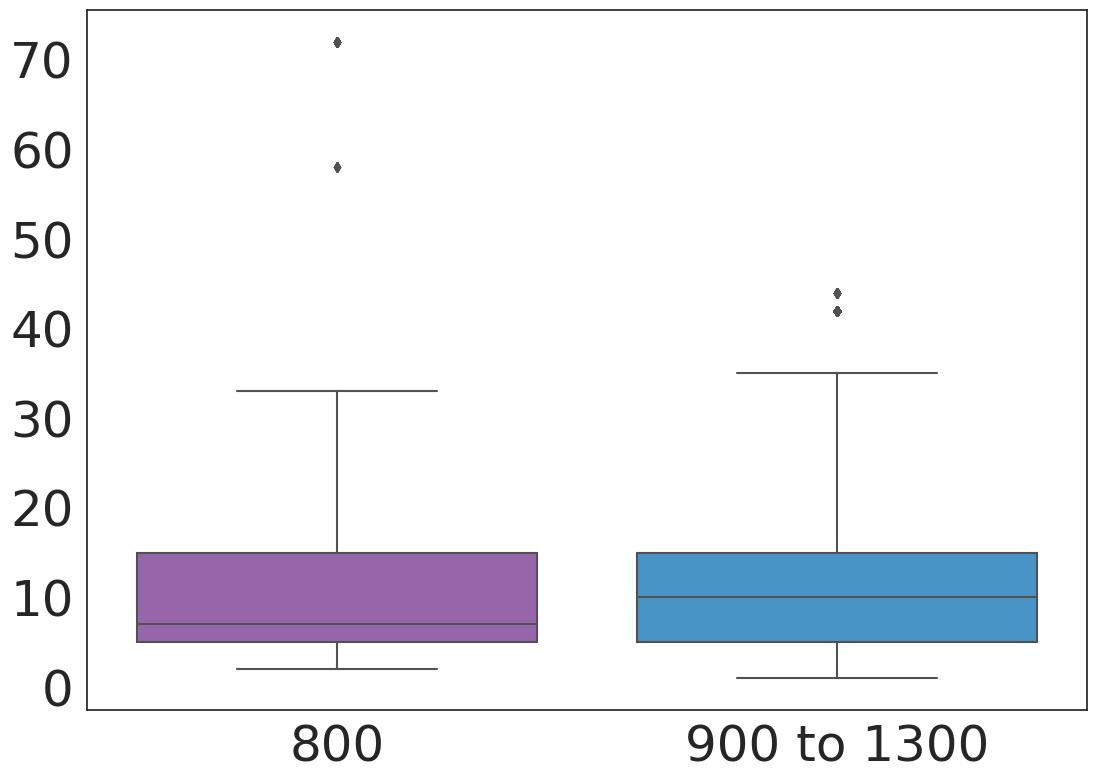

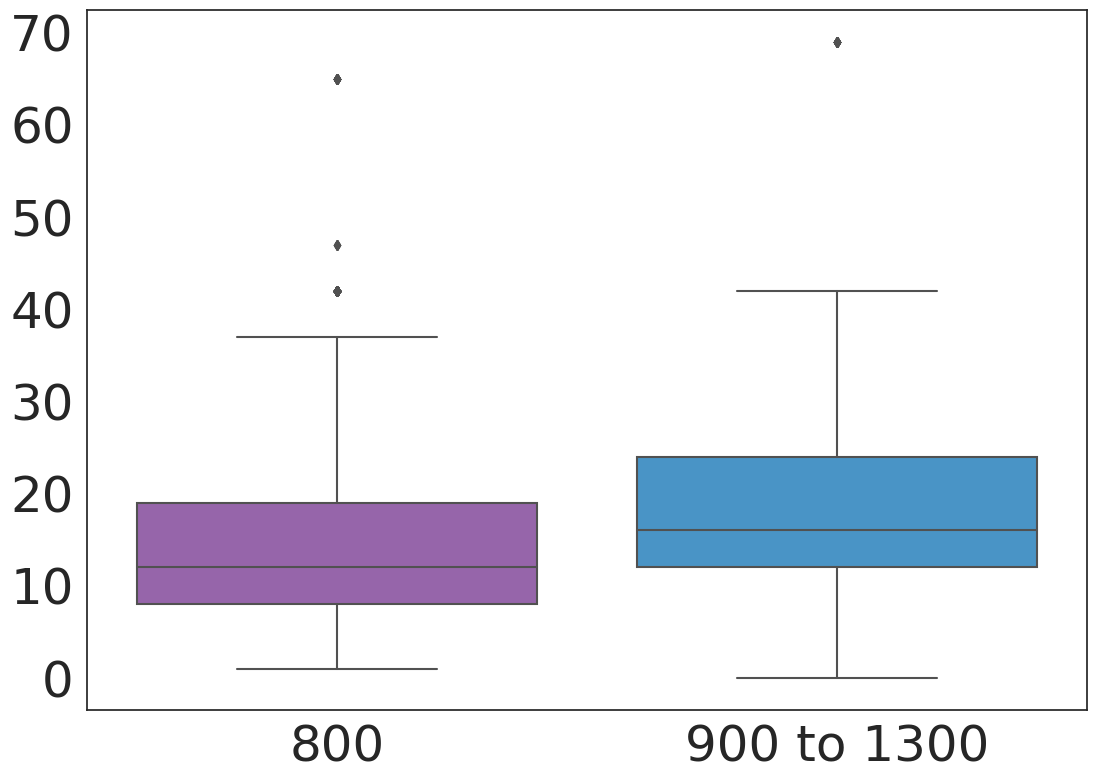

In [54]:
df_after_table7['diff_bin'] = pd.cut(np.array(df_after_table6['Difficulty']), bins=[700,800,1300])
util.plot_box(df_after_table7, figname="figures/locs_by_diff.pdf", 
              xlabel='', ylabel="",
              orient="v",col=['Correct Locs','diff_bin'],
              x_labels=['800', '900 to 1300'],
#               y_labels=[0,10,20,30,40,50,60,70,80],
              figsize=None, whis=2,
              axes=None,font_scale=None,style=None)

util.plot_box(df_after_table7, figname="figures/exprs_by_diff.pdf", 
              xlabel='', ylabel="",
              orient="v",col=['Correct Exprs','diff_bin'],
              x_labels=['800', '900 to 1300'],
#               y_labels=[0,10,20,30,40,50,60,70,80],
              figsize=None, whis=2,
              axes=None,font_scale=None,style=None)

## Figure 18

Technique
CLARA      0.048317
FA(L)      0.456017
FA(L+E)    0.460224
SARFGEN    0.396928
Name: Problem, dtype: float64

/home/mac9908/clara/notebook/clara_dataloader.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


diff_bin     Technique
(700, 800]   CLARA        0.067903
             FA(L)        0.475319
             FA(L+E)      0.482809
             SARFGEN      0.427922
(800, 1300]  CLARA        0.027174
             FA(L)        0.435180
             FA(L+E)      0.435843
             SARFGEN      0.363468
Name: Problem, dtype: float64

/home/mac9908/clara/notebook/clara_dataloader.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


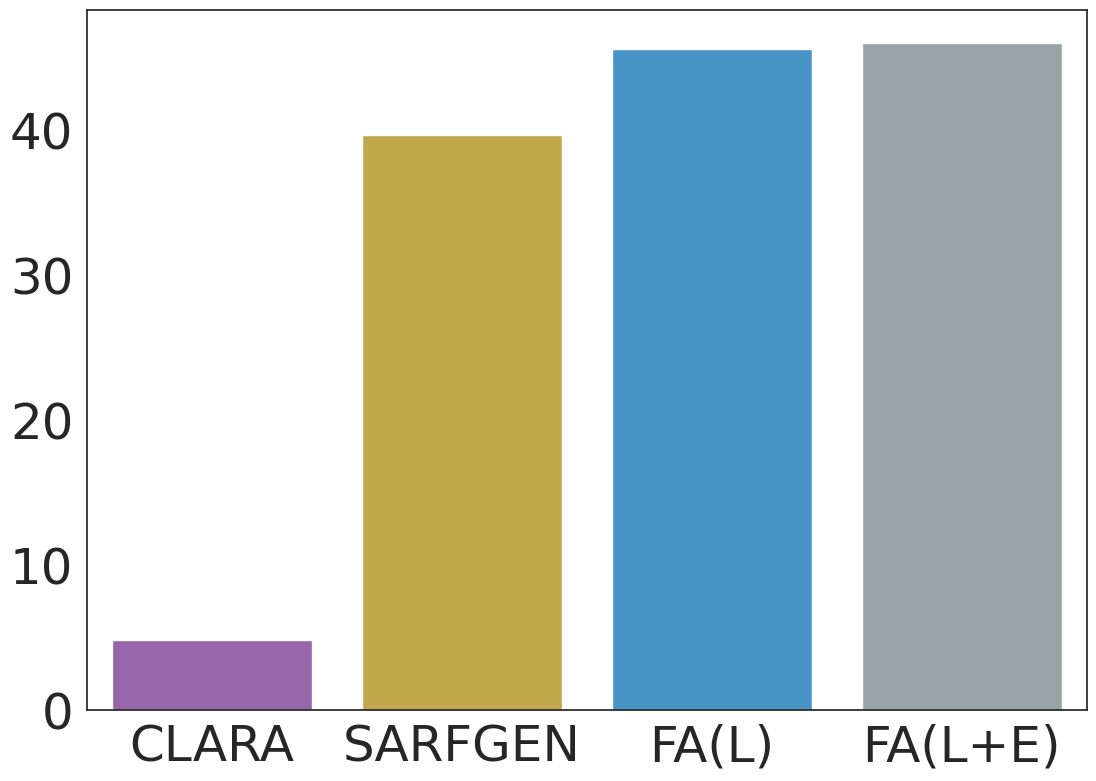

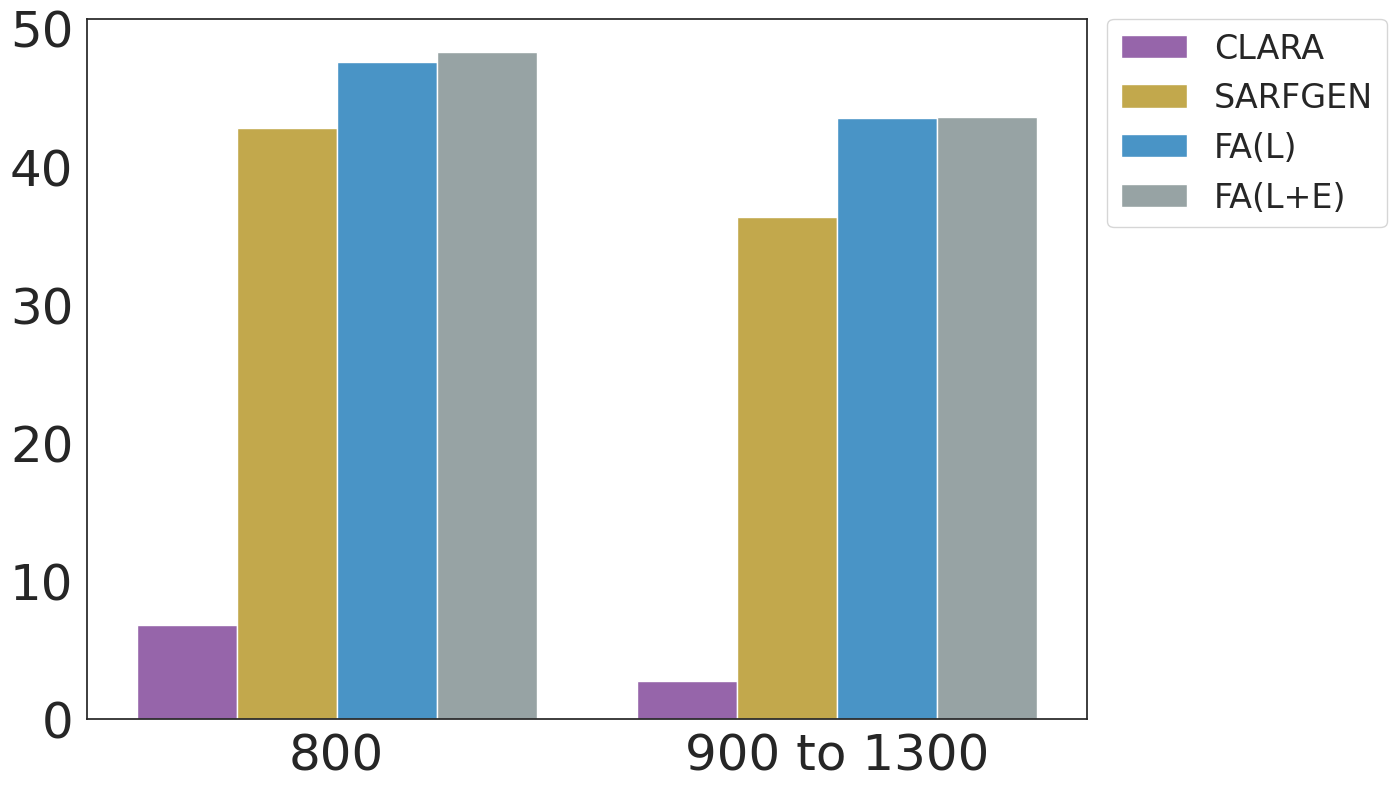

In [55]:
#18a
util.plot_success(df=df_after_table7, figname='figures/successful_repair_by_experiment_v2.pdf',
                  xlabel='', 
#                   x_labels=['CLARA', 'FA(L)', 'FA(L+E)', 'SARFGEN'],
                  order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)']
#                   y_labels=[0,10,20,30,40]
                 )
#18b
util.plot_success(df=df_after_table7, 
                  figname='figures/successful_repair_by_diff_v2.pdf',
                  xlabel='', 
                  legend='upper right',
                  x_labels=['800','900 to 1300'],
                  hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
#                   y_labels=[0,10,20,30,40],
                  col=['diff_bin', 'Technique'])

## Figure 19

locs_bin      Technique
(0.0, 4.0]    CLARA        0.082090
              FA(L)        0.936567
              FA(L+E)      0.937500
              SARFGEN      0.714552
(4.0, 5.0]    CLARA        0.137332
              FA(L)        0.924381
              FA(L+E)      0.926988
              SARFGEN      0.851369
(5.0, 15.0]   CLARA        0.119128
              FA(L)        0.886885
              FA(L+E)      0.899662
              SARFGEN      0.759489
(15.0, 40.0]  CLARA        0.021612
              FA(L)        0.904206
              FA(L+E)      0.917640
              SARFGEN      0.809579
(40.0, 80.0]  CLARA             NaN
              FA(L)        0.550239
              FA(L+E)      0.555024
              SARFGEN      0.449761
Name: Problem, dtype: float64

/home/mac9908/clara/notebook/clara_dataloader.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


exprs_bin     Technique
(0.0, 4.0]    CLARA        0.062500
              FA(L)        0.941810
              FA(L+E)      0.937500
              SARFGEN      0.685345
(4.0, 10.0]   CLARA        0.170319
              FA(L)        0.882279
              FA(L+E)      0.890420
              SARFGEN      0.763306
(10.0, 20.0]  CLARA        0.105650
              FA(L)        0.922013
              FA(L+E)      0.931430
              SARFGEN      0.796645
(20.0, 40.0]  CLARA        0.043946
              FA(L)        0.901345
              FA(L+E)      0.910762
              SARFGEN      0.829148
(40.0, 80.0]  CLARA             NaN
              FA(L)        0.620301
              FA(L+E)      0.624060
              SARFGEN      0.500000
Name: Problem, dtype: float64

/home/mac9908/clara/notebook/clara_dataloader.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


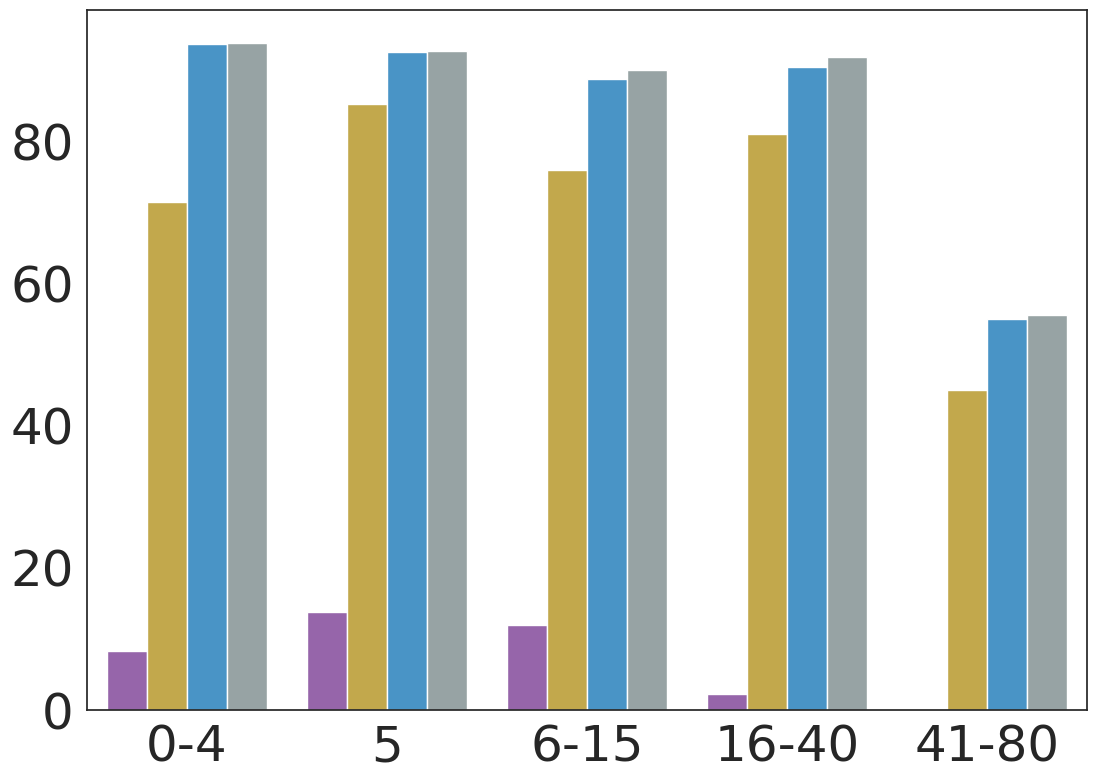

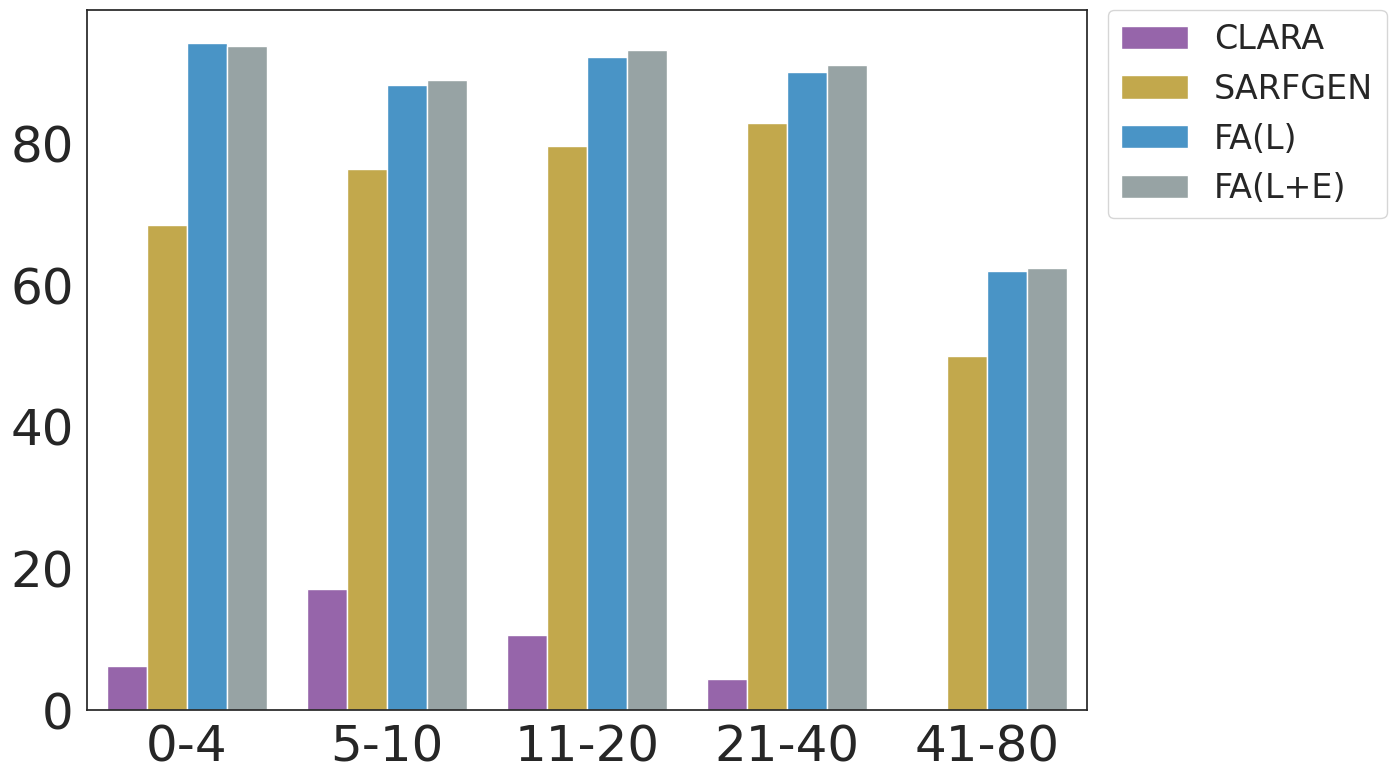

In [56]:
util.plot_success(df=df_after_table7, 
                  figname='figures/successful_repair_by_loc_v2.pdf',
                  xlabel='',
                  x_labels=['0-4','5','6-15','16-40','41-80'],
                  hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
#                   y_labels=[0,10,20,30,40,50,60,70,80,90,100],
                  col=['locs_bin', 'Technique'])
util.plot_success(df=df_after_table7, 
                  figname='figures/successful_repair_by_exprs_v2.pdf',
                  xlabel='',
                  legend='upper right',
                  x_labels=['0-4','5-10','11-20','21-40','41-80'],
                  hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
#                   y_labels=[0,20,40,60,80],
                  col=['exprs_bin', 'Technique'])

## Figure 20

/home/mac9908/clara/notebook/clara_dataloader.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)
/home/mac9908/clara/notebook/clara_dataloader.py:229: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = fontsize)


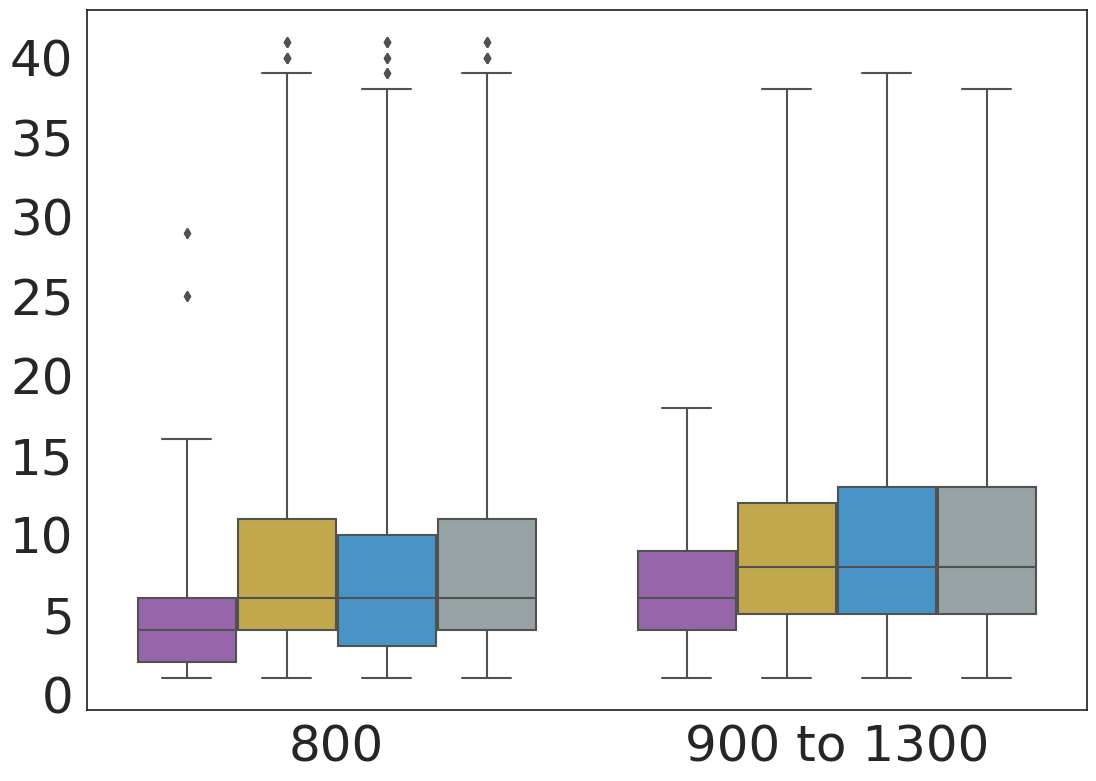

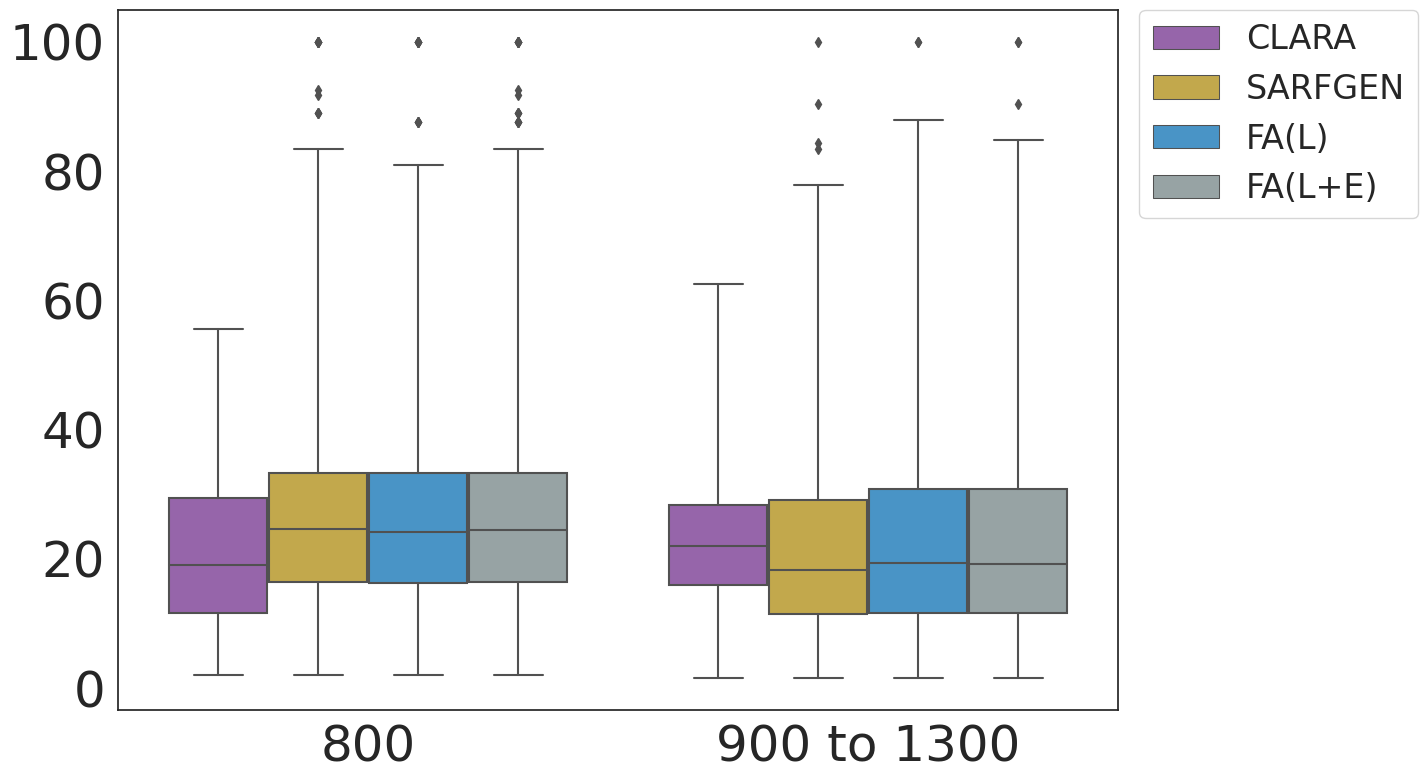

In [57]:
df_fig20 = df_after_table7
df_fig20 = df_fig20[df_fig20['Repairs'].isna() == False]
df_fig20 = df_fig20[df_fig20['Percentage Repaired'].isna() == False]
df_fig20['Repairs'] = df_fig20['Repairs'].astype(int)
df_fig20['Percentage Repaired'] = df_fig20['Percentage Repaired'].astype(float)
# Figure 20a
util.plot_box(df_fig20, figname="figures/repairs_by_diff_v2.pdf", 
              xlabel='', ylabel="",hue='Technique',
              orient="v",col=['Repairs','diff_bin'],
              x_labels=['800', '900 to 1300'],
              hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
#               y_labels=[0,0,20,40,60,80,100],
              figsize=None, whis=4,
              axes=None,font_scale=None,style=None)
# Figure 20b
util.plot_box(df_fig20, figname="figures/percentage_repaired_by_diff_v2.pdf", 
              xlabel='', ylabel="",
              hue='Technique',
              orient="v",col=['Percentage Repaired','diff_bin'],
              x_labels=['800', '900 to 1300'],
              hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
#               y_labels=[0,0,20,40,60,80,100],
              figsize=None, whis=3, legend='upper right',
              axes=None,font_scale=None,style=None)

## Figure 21

/tmp/ipykernel_21039/1953314248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig19['Repairs'] = df_fig19['Repairs'].astype(int)
/tmp/ipykernel_21039/1953314248.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = 24)
/tmp/ipykernel_21039/1953314248.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
/tmp/ipykernel_21039/1953314248.py:38: Us

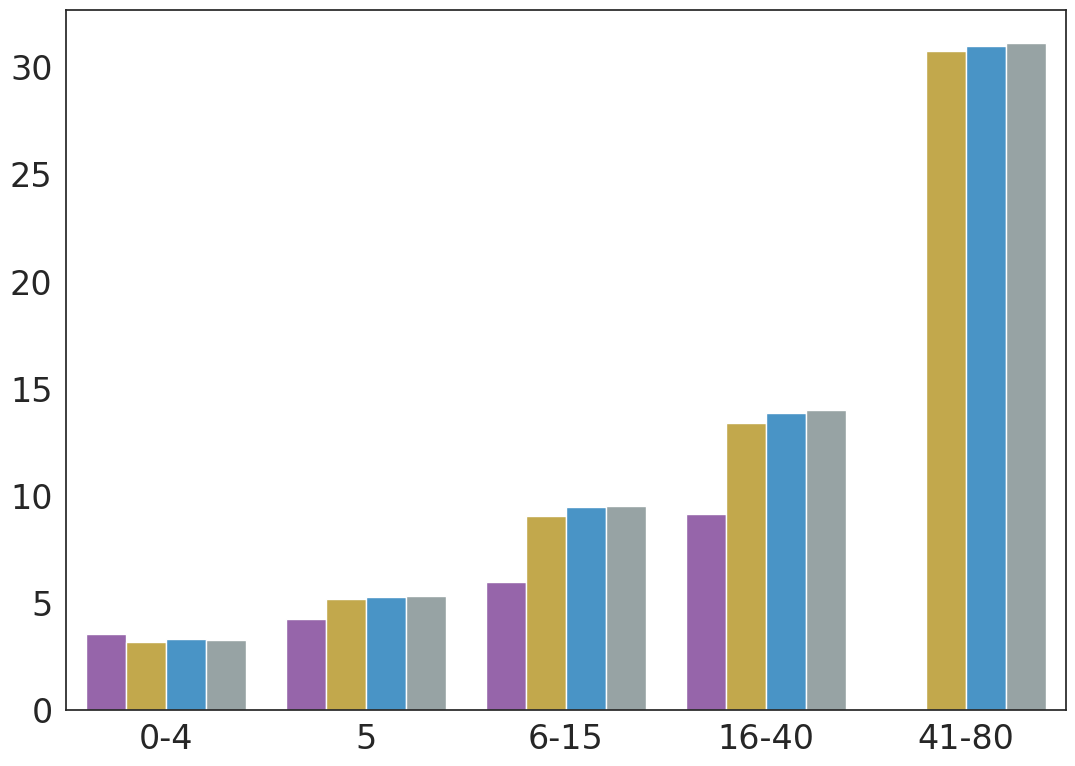

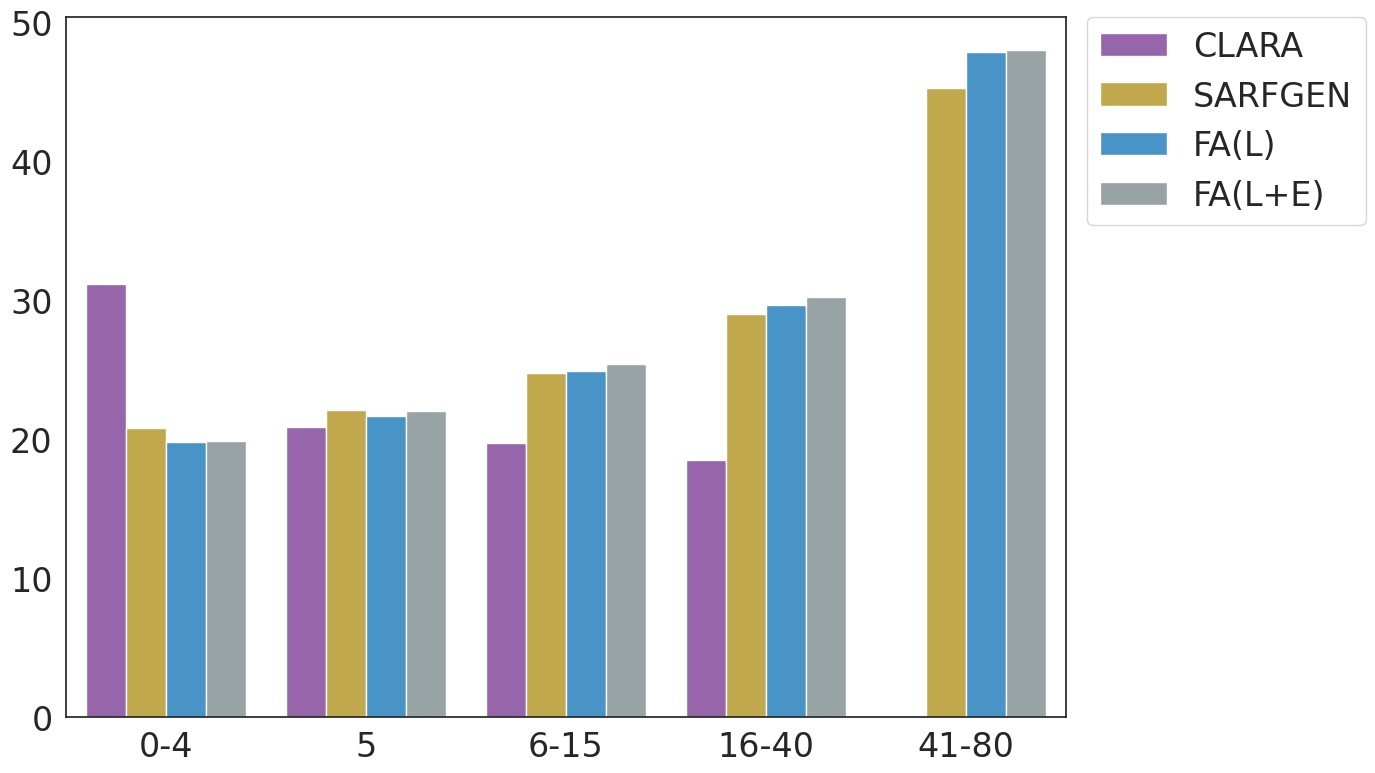

In [58]:
# display(df_after_table7)
# Fig 21a
df_fig19 = df_after_table7
df_fig19 = df_fig19[df_fig19['Repairs'].isna() == False]
df_fig19['Repairs'] = df_fig19['Repairs'].astype(int)
locs = df_fig19.groupby([ 'Technique', 'locs_bin'])['Repairs'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('locs_bin'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=util.palette,
              hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(ax.get_yticklabels(), size = 24)
ax.set_xticklabels(["0-4","5","6-15","16-40","41-80"], size = 24)
ax.legend([], [], frameon=False)
plt.savefig('figures/number_of_repairs_by_loc_v2.pdf', format="pdf", bbox_inches='tight')


# Fig 21b
df_fig19 = df_after_table7
df_fig19 = df_fig19[df_fig19['Repairs'].isna() == False]
df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
exprs = df_fig19.groupby([ 'Technique', 'locs_bin'])['Percentage Repaired'].mean()
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=exprs.index.get_level_values('locs_bin'),
            hue=exprs.index.get_level_values('Technique'), 
            y=exprs.values, ax=ax, palette=util.palette,
              hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(ax.get_yticklabels(), size = 24)
ax.set_xticklabels(["0-4","5","6-15","16-40","41-80"], size = 24)
# ax.set_xticklabels(["0-4","5","11-20", "21-40", "41-80"], size = 24)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1), borderaxespad=0, fontsize=24)
plt.savefig('figures/average_percentage_repaired_by_loc_v2.pdf', format="pdf", bbox_inches='tight')

### Structure Mismatch

In [59]:
df_after_table7.groupby(['Technique', 'Structure Mismatch'])['Technique'].count()

Technique  Structure Mismatch
CLARA      False                  1235
           True                  14453
FA(L)      False                 15688
FA(L+E)    False                 15688
SARFGEN    False                 15688
Name: Technique, dtype: int64

## Figure 22

Problem  Technique
1097A    CLARA        0.013636
         FA(L)        0.227273
         FA(L+E)      0.231818
         SARFGEN      0.220455
1360B    CLARA        0.186441
                        ...   
50A      SARFGEN      0.656085
510A     CLARA             NaN
         FA(L)        0.483483
         FA(L+E)      0.621622
         SARFGEN      0.558559
Name: Problem, Length: 80, dtype: float64


/tmp/ipykernel_21039/3868425442.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=18)


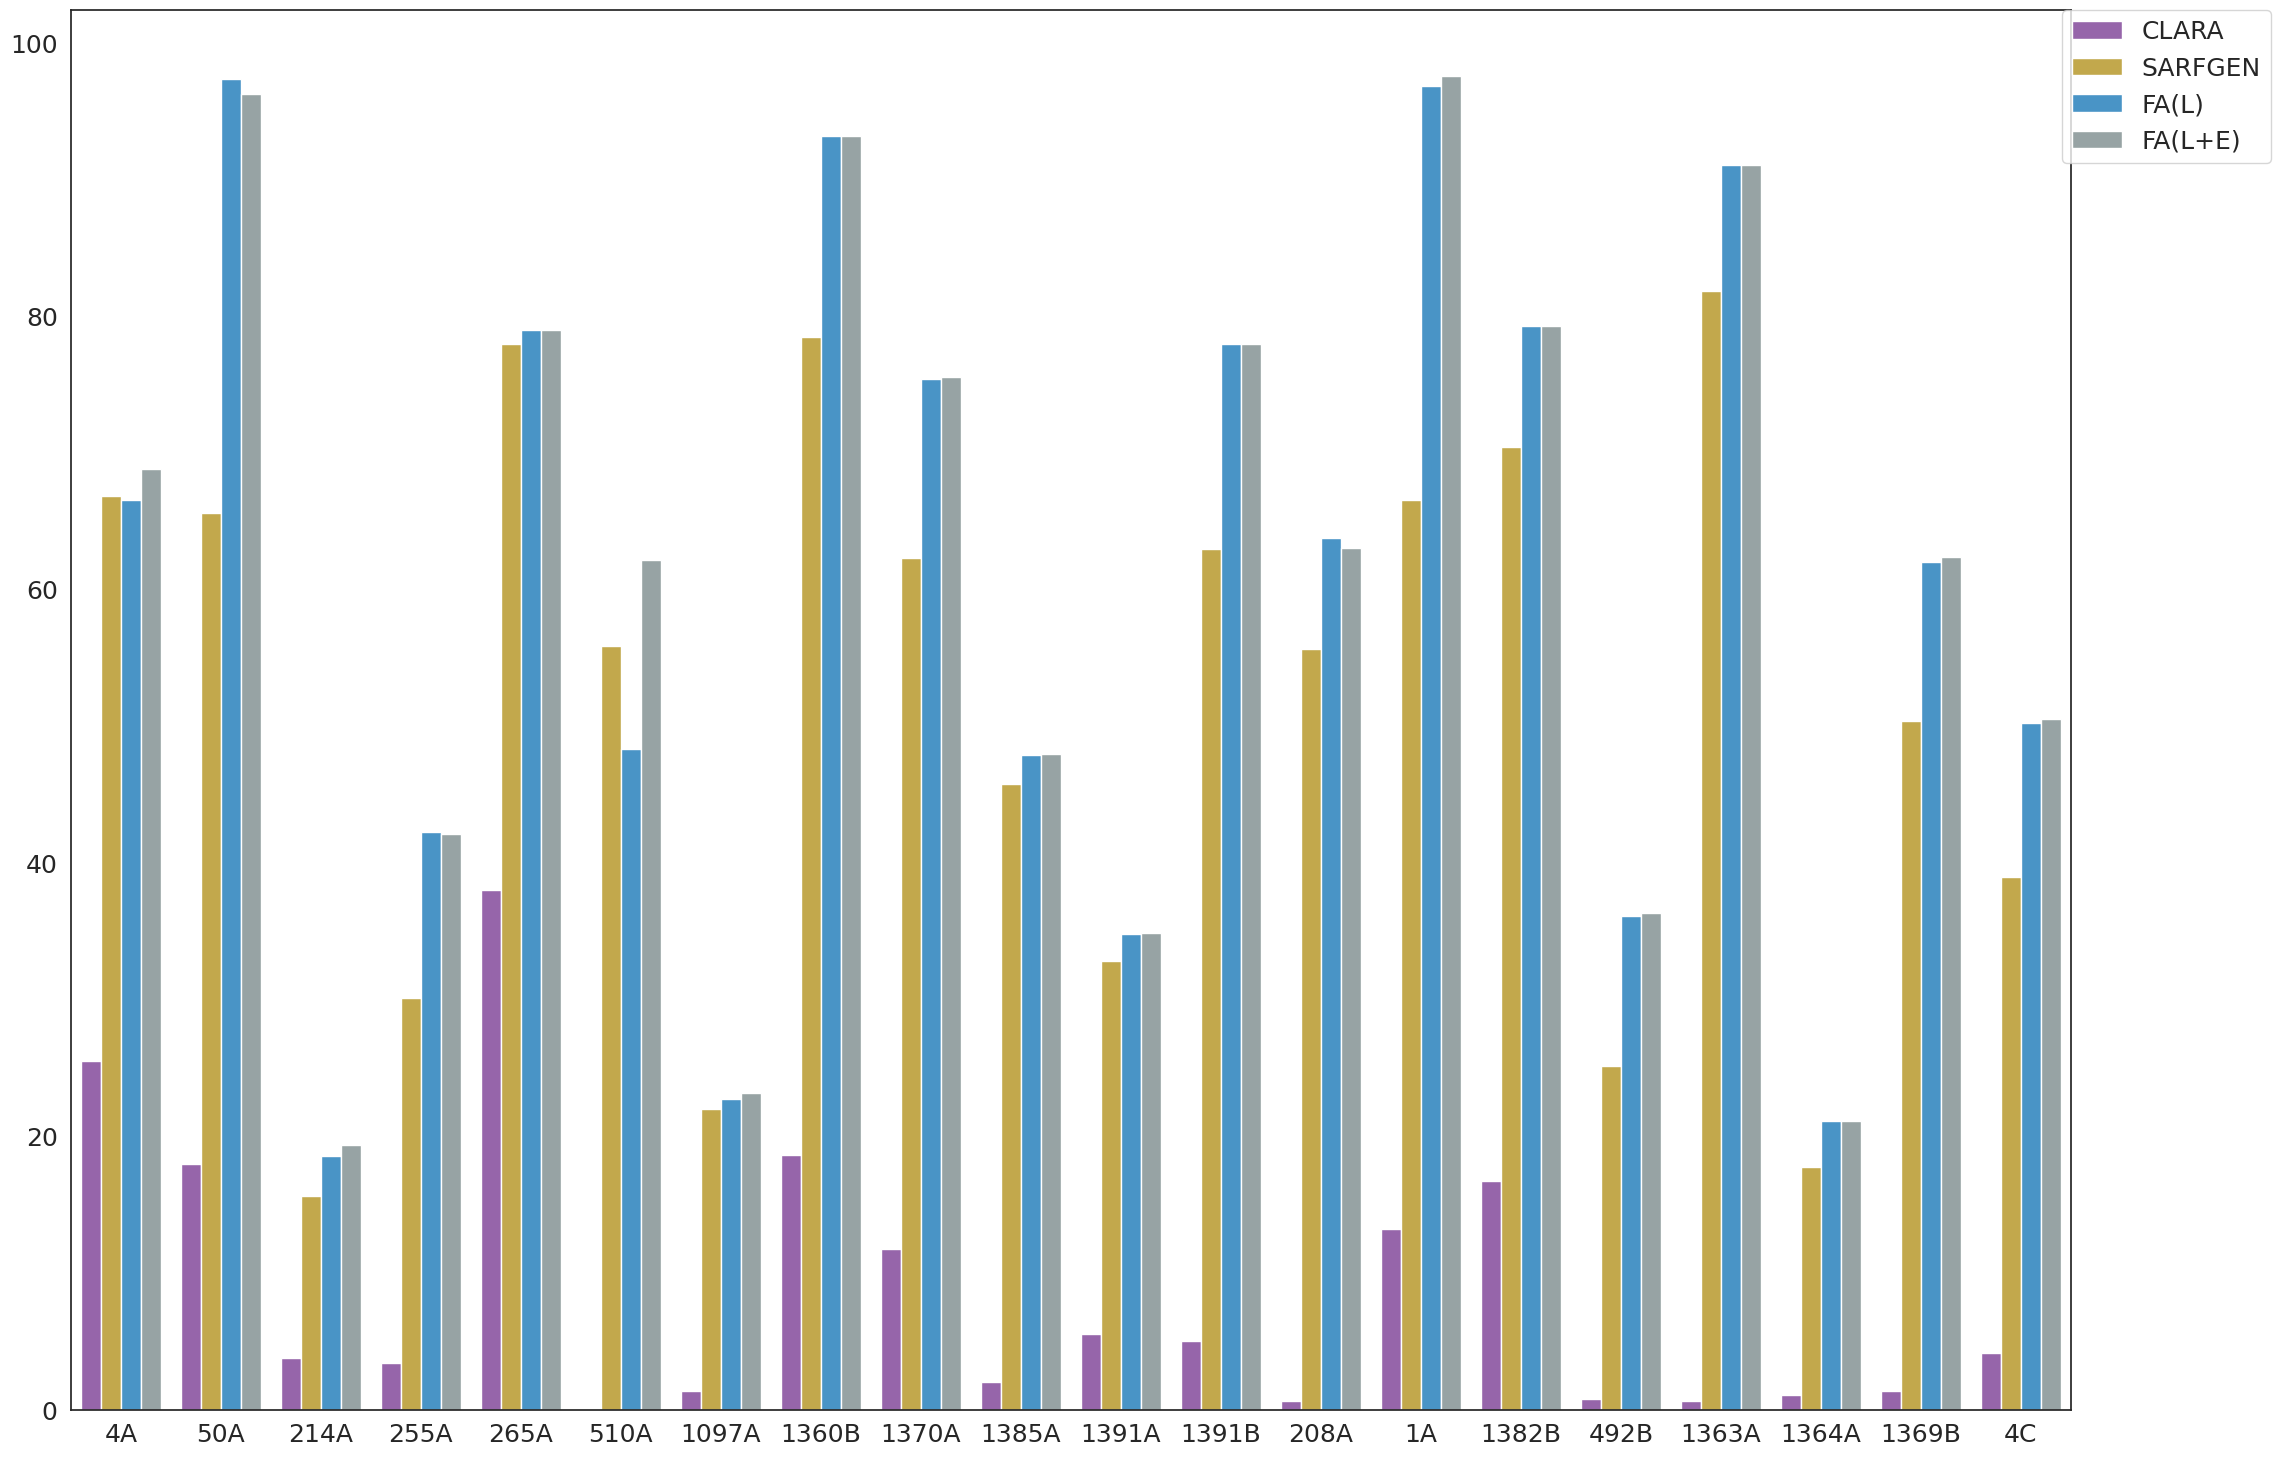

In [60]:
repaired_tech_problem = util.successful_repair_percentage(df_after_table7, col=['Problem', 'Technique'])
print(repaired_tech_problem)
sns.set(font_scale=1)
sns.set_style("white")
fig = plt.figure(figsize =(20, 14))
ax = fig.add_axes([0, 0, 1, 1])
sns.barplot(x=repaired_tech_problem.index.get_level_values('Problem'),
            hue=repaired_tech_problem.index.get_level_values('Technique'), 
            y=repaired_tech_problem.values*100, ax=ax, palette=util.palette,
              hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
            order=util.order)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), size=18)
ax.set_yticklabels(ax.get_yticklabels(), size=18)
ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), borderaxespad=0, fontsize=18)
plt.savefig('figures/successful_repair_by_problem_v2.pdf', format="pdf", bbox_inches='tight')

### Figure 22 addendum

In [61]:
repaired_tech_problem = util.successful_repair_percentage(df_after_table7, col=['Problem', 'Technique'])
tmp = df_after_table7[df_after_table7['Problem'] == '510A'][['Technique', 'Correct Locs', 'ci']]
tmp

,Technique,Correct Locs,ci
30436,CLARA,NaN,122288372_86894470
30437,FA(L),15.0,122288372_86894470
30438,FA(L+E),15.0,122288372_86894470
30442,CLARA,NaN,18717839_86894470
30443,FA(L),NaN,18717839_86894470
...,...,...,...
32741,SARFGEN,NaN,111340510_105048445
32747,SARFGEN,27.0,97523932_105048445
32750,SARFGEN,15.0,47853984_105048445
32753,SARFGEN,15.0,86147096_105048445


## Figure 23

/tmp/ipykernel_21039/3778089544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)


Problem  Technique
1097A    CLARA        18.230723
         FA(L)        31.872220
         FA(L+E)      32.216801
         SARFGEN      32.216801
1360B    CLARA        24.341321
                        ...    
50A      FA(L+E)      18.839593
         SARFGEN      18.839593
510A     FA(L)        21.698204
         FA(L+E)      33.272690
         SARFGEN      33.272690
Name: Percentage Repaired, Length: 79, dtype: float64


/tmp/ipykernel_21039/3778089544.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size = 18)


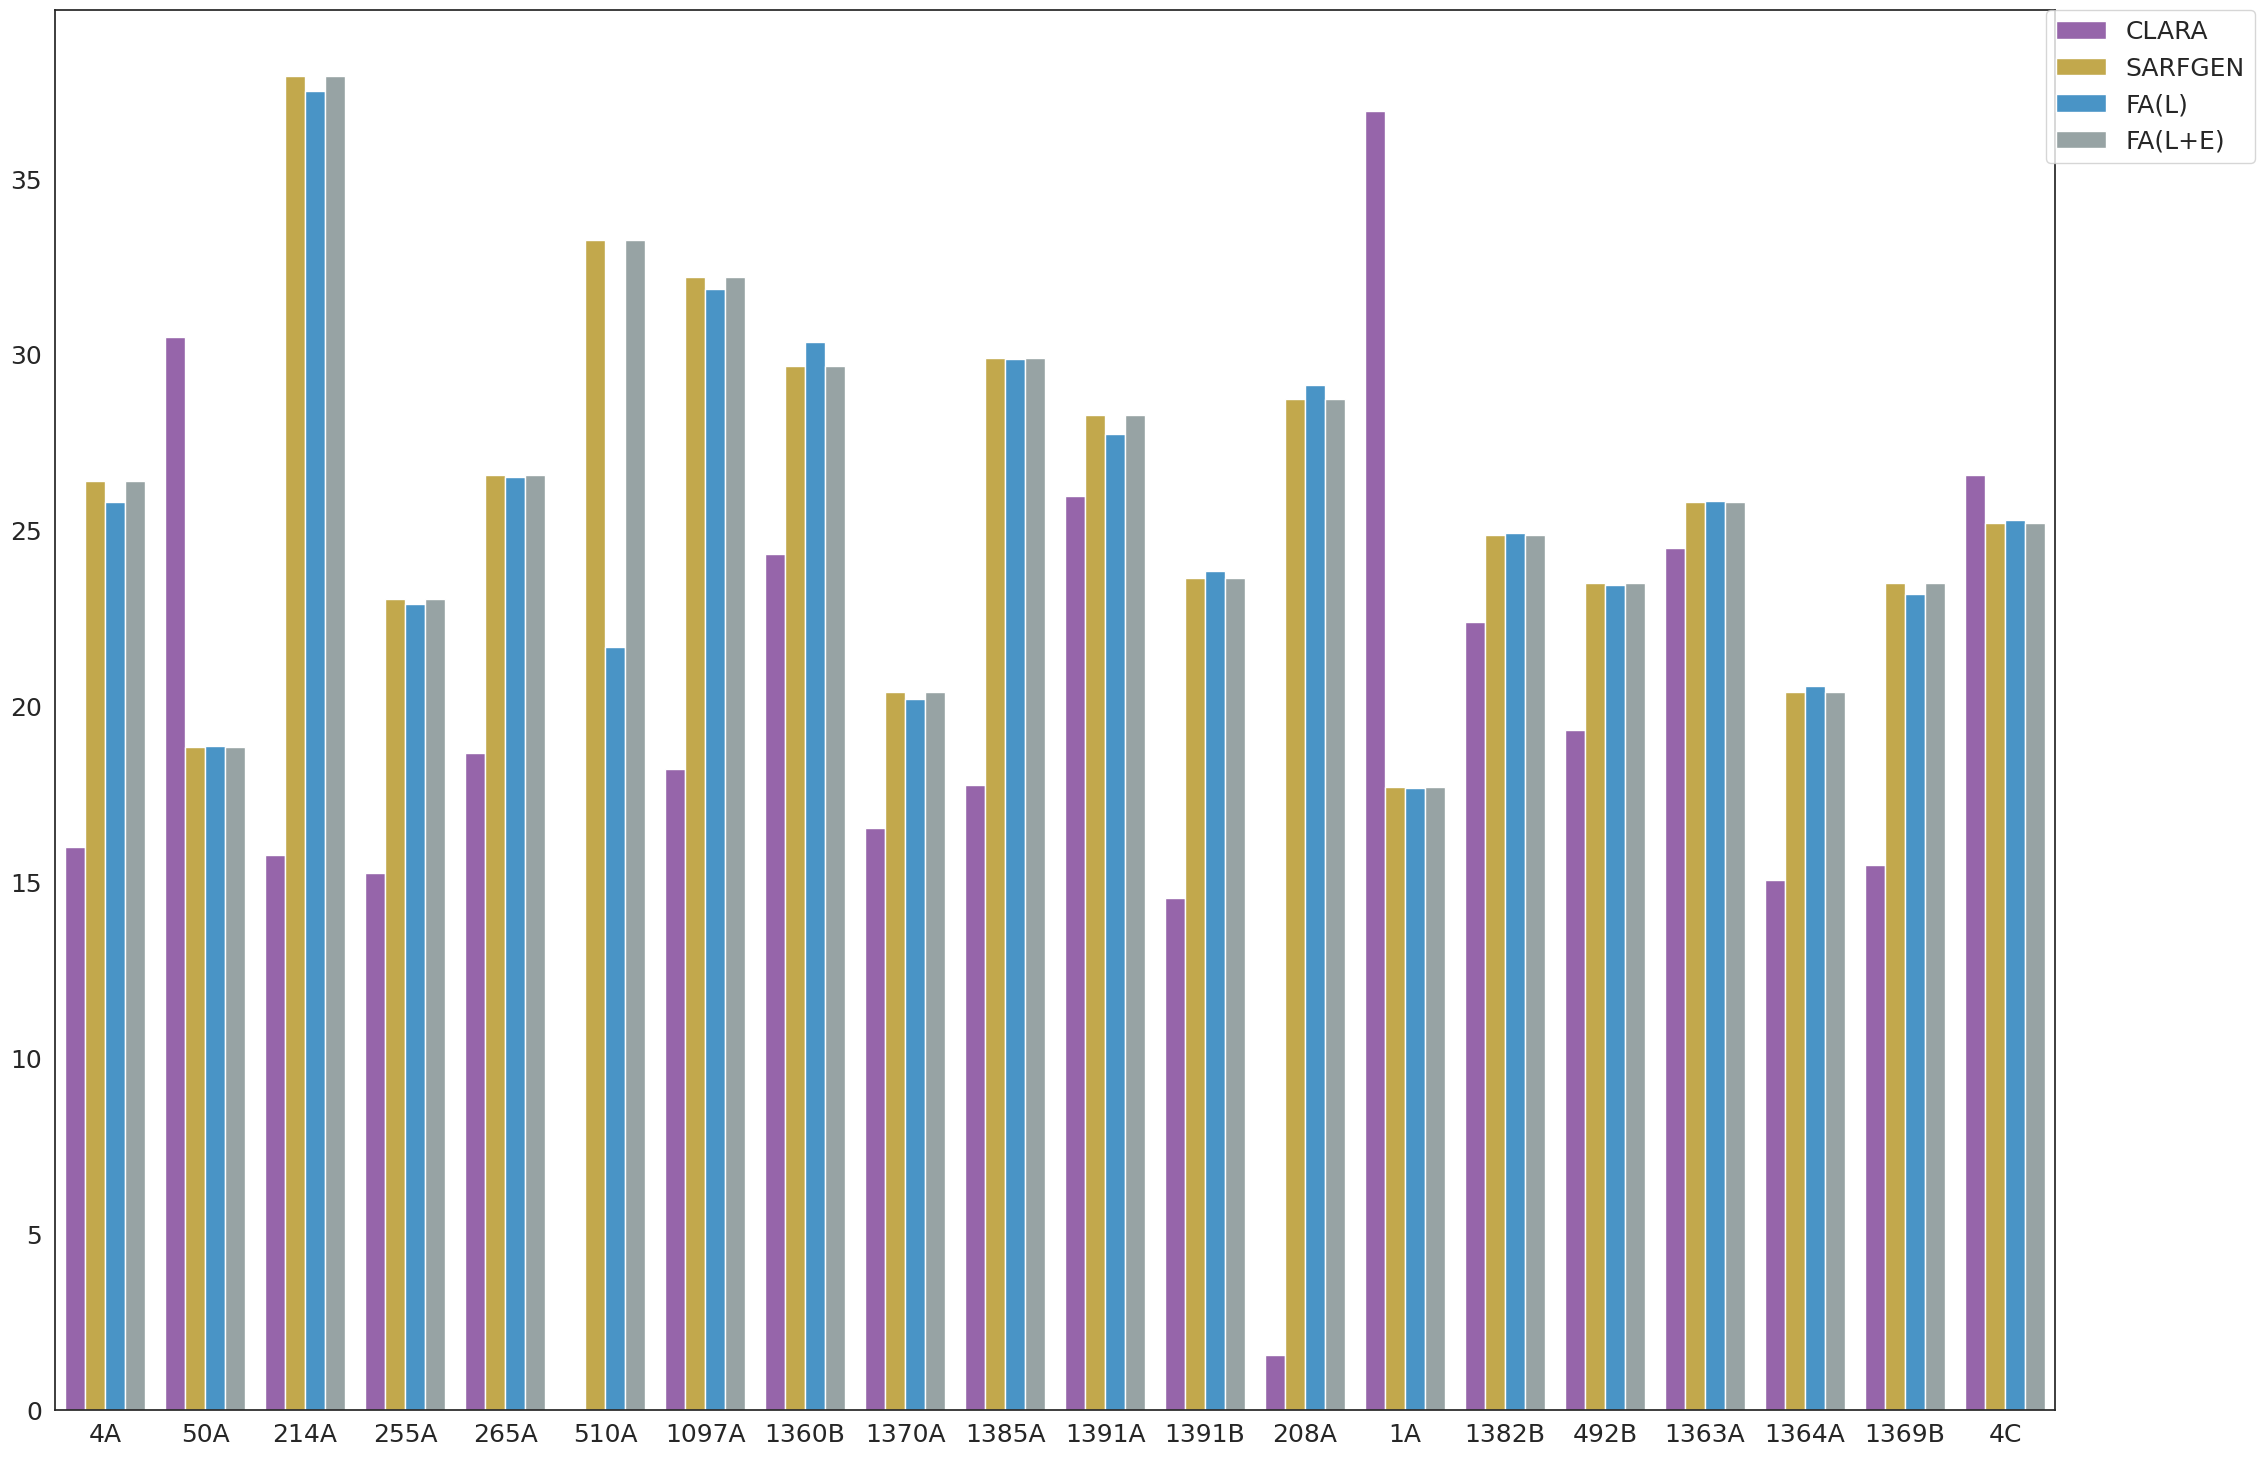

In [62]:
df_fig19 = df_after_table7
df_fig19 = df_fig19[df_fig19['Percentage Repaired'].isna() == False]
df_fig19['Percentage Repaired'] = df_fig19['Percentage Repaired'].astype(float)
locs = df_fig19.groupby([ 'Problem', 'Technique'])['Percentage Repaired'].mean()
print(locs)
fig = plt.figure(figsize =(20, 14))
ax = fig.add_axes([0, 0, 1, 1])
# sns.set(font_scale=1.5)
sns.set_style("white")
sns.barplot(x=locs.index.get_level_values('Problem'),
            hue=locs.index.get_level_values('Technique'), 
            y=locs.values, ax=ax, palette=util.palette,hue_order=['CLARA', 'SARFGEN', 'FA(L)', 'FA(L+E)'],
           order=util.order)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticklabels(ax.get_yticklabels(), size = 18)
ax.set_xticklabels(ax.get_xticklabels(), size = 18)
# ax.legend([], [], frameon=False)
ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1), borderaxespad=0, fontsize=18)
plt.savefig('figures/percentage_repaired_by_problem_v2.pdf', format="pdf", bbox_inches='tight')

In [65]:
df_after_table7[df_after_table7['Repairs'].isna()!=True].groupby('Difficulty')['Problem'].count()

Difficulty
800     11841
900       273
1000      787
1100     1246
1200     6691
1300      521
Name: Problem, dtype: int64